In [1]:
from fastai.vision.all import *
import pandas as pd
import cam
import util

In [2]:
# Use small bs as we have very limited data due to conditional hierarchy filtering
dls, labels = util.chexpert_data_loader(use_hierarchy=True, bs=4)

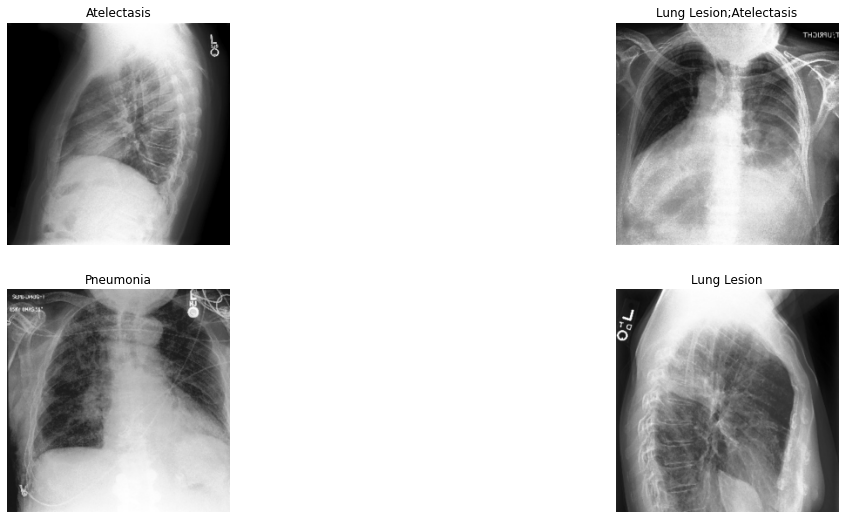

In [3]:
dls.show_batch(max_n=9, figsize=(20,9))

In [4]:
# First train on conditional probabilities
chexpert_learner_conditional = util.ChexpertLearner(dls, xse_resnext50, n_out=len(labels),
                                        loss_func=BCEWithLogitsLossFlat(),
                                        metrics=[RocAucMulti(average=None),
                                                 RocAucMulti(average='weighted')])

lr_min/10: 5.754399462603033e-05, lr_steep: 9.12010818865383e-07, base_lr: 5.754399462603033e-05


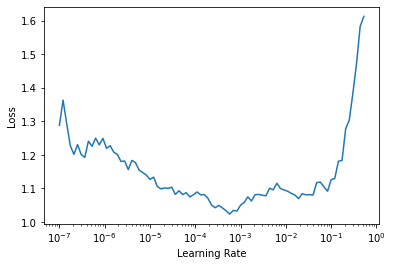

In [5]:
chexpert_learner_conditional.find_lr()

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.991147,0.704257,[0.5446371 0.63216065 0.54478483 0.59623862],0.594005,01:04


Better model found at epoch 0 with valid_loss value: 0.7042566537857056.


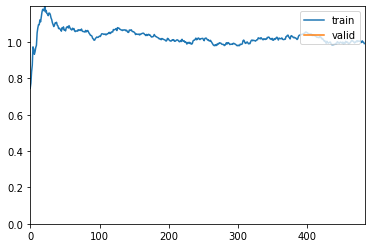

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.943036,0.679758,[0.60617421 0.65049467 0.54567441 0.56462278],0.599959,01:39
1,0.890293,0.686258,[0.61206139 0.64515013 0.55787835 0.54818254],0.595480,01:38
2,0.931598,0.697919,[0.62081893 0.64701813 0.55154009 0.58471239],0.608168,01:38
3,0.901528,0.669238,[0.60711148 0.64137955 0.5509285 0.58933733],0.605420,01:39
4,0.886063,0.654916,[0.66633472 0.65999031 0.55815634 0.60917401],0.628611,01:37
5,0.863480,0.641108,[0.61601546 0.64604954 0.51770822 0.61385316],0.611099,01:38
6,0.810381,0.645294,[0.62486088 0.66526567 0.54434004 0.59755745],0.618585,01:39
7,0.824222,0.643290,[0.6758245 0.6554241 0.55406983 0.59080069],0.621769,01:43
8,0.813478,0.614081,[0.62588601 0.65537222 0.55212387 0.5957689 ],0.615680,01:46
9,0.762829,0.615155,[0.60673071 0.66037083 0.55732236 0.57166859],0.607835,01:41


Better model found at epoch 0 with valid_loss value: 0.6797578930854797.


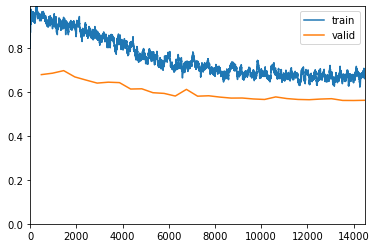

Epoch 2: reducing lr to 1.1501596670059834e-06
Better model found at epoch 3 with valid_loss value: 0.6692383289337158.
Better model found at epoch 4 with valid_loss value: 0.6549158692359924.
Better model found at epoch 5 with valid_loss value: 0.6411083340644836.
Epoch 7: reducing lr to 2.8075083959842547e-06
Better model found at epoch 8 with valid_loss value: 0.6140814423561096.
Better model found at epoch 10 with valid_loss value: 0.5973090529441833.
Better model found at epoch 11 with valid_loss value: 0.5941727757453918.
Better model found at epoch 12 with valid_loss value: 0.5821093320846558.
Better model found at epoch 14 with valid_loss value: 0.5815176963806152.
Better model found at epoch 16 with valid_loss value: 0.5773251056671143.
Better model found at epoch 17 with valid_loss value: 0.5728176832199097.
Better model found at epoch 19 with valid_loss value: 0.5688267350196838.
Better model found at epoch 20 with valid_loss value: 0.5665468573570251.
Epoch 22: reducing lr 

In [6]:
chexpert_learner_conditional.learn_model(use_saved=False, epochs=30)

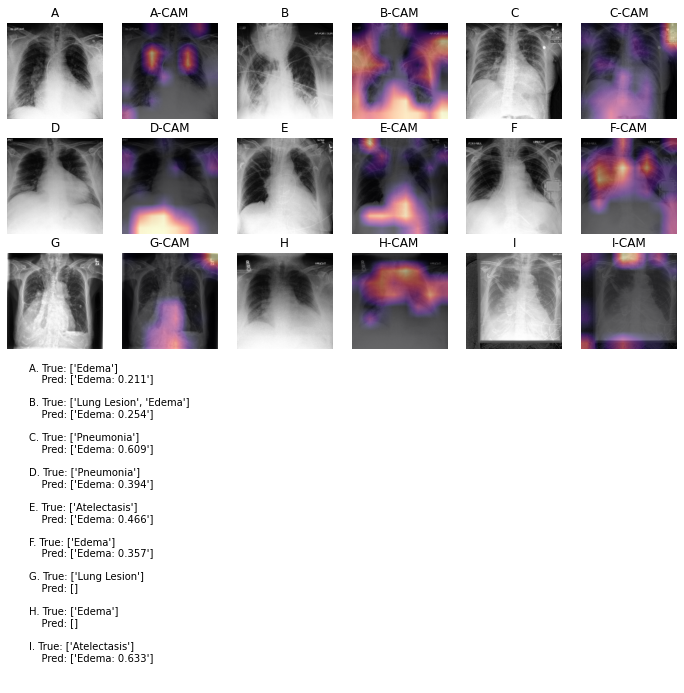

In [7]:
# Let us see how the conditional model predicts - use the saved optimal model
chexpert_learner = cnn_learner(dls, xse_resnext50, path=Path('../saves/'))
chexpert_learner.load('xse_resnext50-chexpert', with_opt=True)
cam.plot_cam(chexpert_learner)

In [8]:
# Reload the data as it may have been modified for conditional probs
dls, labels = util.chexpert_data_loader()

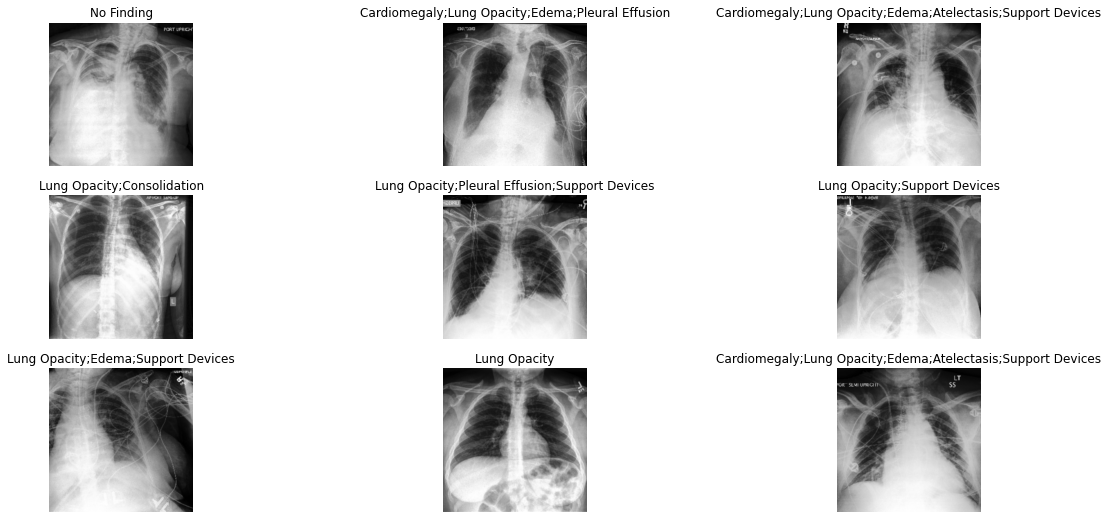

In [9]:
dls.show_batch(max_n=9, figsize=(20,9))

In [10]:
# Next train unconditionally for only transfer learning
chexpert_learner_unconditional = util.ChexpertLearner(dls, xse_resnext50, n_out=len(labels),
                                        loss_func=BCEWithLogitsLossFlat(),
                                        metrics=[RocAucMulti(average=None),
                                                 RocAucMulti(average='weighted')])

lr_min/10: 0.017378008365631102, lr_steep: 0.04786301031708717, base_lr: 0.04786301031708717


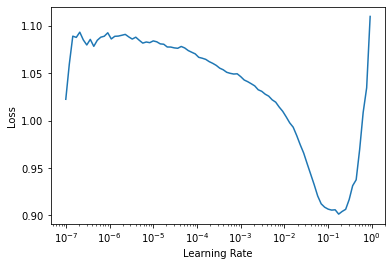

In [11]:
chexpert_learner_unconditional.find_lr()

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.327070,0.324246,[0.79913947 0.54603456 0.66365479 0.67264603 0.66505398 0.77036303 0.63218406 0.62543424 0.62009276 0.70899995 0.75197148 0.69953278 0.64397995 0.75621827],0.712779,45:02
1,0.330996,0.319069,[0.81254963 0.58223774 0.70328804 0.68190535 0.67818653 0.78280749 0.64791417 0.62466476 0.62819284 0.72643709 0.77278531 0.7144942 0.65461742 0.76580932],0.727157,45:04
2,0.320731,0.318133,[0.81972858 0.57552133 0.72556341 0.68298634 0.6621509 0.78672351 0.65012042 0.63673017 0.62651106 0.72779061 0.78008383 0.71361409 0.65922189 0.76910006],0.731022,45:05
3,0.325867,0.316556,[0.82046855 0.57665278 0.7397603 0.68391276 0.67556311 0.78582813 0.64903835 0.62232048 0.63150596 0.73985312 0.79049165 0.71232924 0.66137032 0.77215641],0.735201,44:59
4,0.325892,0.316063,[0.82919808 0.59030124 0.74995771 0.68836679 0.67686868 0.7909928 0.66190625 0.63206035 0.63322383 0.73936392 0.80033795 0.713539 0.66105267 0.7738672 ],0.740475,45:00


Better model found at epoch 0 with valid_loss value: 0.32424572110176086.


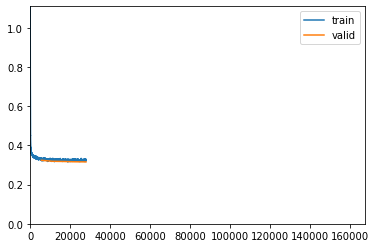

Better model found at epoch 1 with valid_loss value: 0.31906858086586.
Better model found at epoch 2 with valid_loss value: 0.31813332438468933.
Better model found at epoch 3 with valid_loss value: 0.31655558943748474.
Better model found at epoch 4 with valid_loss value: 0.31606265902519226.


In [ ]:
# Freeze the body and update the weights for the last layer
chexpert_learner_unconditional.learn_model(use_saved=True, train_saved=True, old_learner=chexpert_learner_conditional.learn, epochs=0, freeze_epochs=30)

In [ ]:
# Unfreeze the body and update the whole model end-to-end
chexpert_learner_unconditional.learn_model(use_saved=True, train_saved=True, epochs=30, freeze_epochs=0)

In [ ]:
chexpert_learner = cnn_learner(dls, xse_resnext50, path=Path('../saves/'))
chexpert_learner.load('xse_resnext50-chexpert', with_opt=True)
cam.plot_cam(chexpert_learner)

In [ ]:
# Save the final model
chexpert_learner_unconditional.learn.save('xse_resnext50-chexpert-final')